<a href="https://colab.research.google.com/github/tanwir1703/Object-Recognition/blob/main/Transformer_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install trimesh

     |████████████████████████████████| 634kB 8.1MB/s 


Trimesh is a pure Python (2.7-3.4+) library for loading and using triangular meshes with an emphasis on watertight surfaces. The goal of the library is to provide a full featured and well tested Trimesh object which allows for easy manipulation and analysis, in the style of the Polygon object in the Shapely library.

We can use the trimesh package to read and visualize the .off CAD models.

In [ ]:
import trimesh
import glob
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://modelnet.cs.princeton.edu/ModelNet40.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet40")

2039185408/2039180837 [==============================] - 50s 0us/step


In [ ]:
val = os.path.join(DATA_DIR, "airplane/train/airplane_0002.off")
mesh = trimesh.load(val) 
mesh.show()

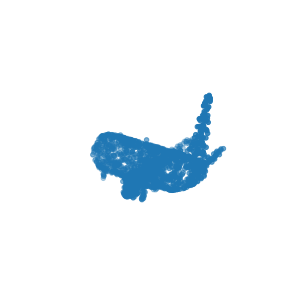

In [ ]:
points = mesh.sample(2000)
#sample function of the trimesh library randomly samples surface and volume of meshes.

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [ ]:
def parse_dataset(num_points=2000):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("Parsing through the folder: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [ ]:
NUM_POINTS = 2000
NUM_CLASSES = 40
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

Parsing through the folder: night_stand
Parsing through the folder: bed
Parsing through the folder: airplane
Parsing through the folder: stool
Parsing through the folder: bottle
Parsing through the folder: lamp
Parsing through the folder: range_hood
Parsing through the folder: flower_pot
Parsing through the folder: bowl
Parsing through the folder: curtain
Parsing through the folder: sink
Parsing through the folder: xbox
Parsing through the folder: keyboard
Parsing through the folder: mantel
Parsing through the folder: sofa
Parsing through the folder: door
Parsing through the folder: stairs
Parsing through the folder: monitor
Parsing through the folder: plant
Parsing through the folder: wardrobe
Parsing through the folder: radio
Parsing through the folder: tv_stand
Parsing through the folder: bench
Parsing through the folder: bathtub
Parsing through the folder: person
Parsing through the folder: chair
Parsing through the folder: tent
Parsing through the folder: car
Parsing through the f

### Data Augmentation

Techniques are used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. Here we have followed jittering as our augmentation technique.

In [ ]:
def augment(points, label):
    # jitter points 
    # tf random uniform outputs random values from a uniform distribution where second and third arguments are lower and upper bounds([-0.005,0.005)).
    # Returns a tensor of the specified shape filled with random uniform values.
    # Jittering is adding random noise to a plot can sometimes make it easier to read. The basic idea
    
    
     is to provide small random movements to plotted points.
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    # tf random shuffle randomly shuffles a tensor along its first dimension.
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

# Layers used to build ConvNets

A covnets is a sequence of layers, and every layer transforms one volume to another through differentiable function.
Types of layers:

Let’s take an example by running a covnets on of image of dimension 32 x 32 x 3.

**Input Layer**: This layer holds the raw input of image with width 32, height 32 and depth 3.

**Convolution Layer**: This layer computes the output volume by computing dot product between all filters and image patch. Suppose we use total 12 filters for this layer we’ll get output volume of dimension 32 x 32 x 12.

**Activation Function Layer**: This layer will apply element wise activation function to the output of convolution layer. Some common activation functions are RELU: max(0, x), Sigmoid: 1/(1+e^-x), Tanh, Leaky RELU, etc. The volume remains unchanged hence output volume will have dimension 32 x 32 x 12.

**Pool Layer**: This layer is periodically inserted in the covnets and its main function is to reduce the size of volume which makes the computation fast reduces memory and also prevents from overfitting. Two common types of pooling layers are max pooling and average pooling. If we use a max pool with 2 x 2 filters and stride 2, the resultant volume will be of dimension 16x16x12.


**Fully-Connected Layer**: This layer is regular neural network layer which takes input from the previous layer and computes the class scores and outputs the 1-D array of size equal to the number of classes.

#### Batch Normalization
Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the layers' inputs by re-centering and re-scaling. Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        y = tf.tensordot(x, x, axes=(2, 2))
        y = tf.reshape(y, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(self.eye - y))

##Network Architecture
The first transformation network is a mini-PointNet that
takes raw point cloud as input and regresses to a 3 × 3
matrix. It’s composed of a shared MLP(64, 128, 1024)
network (with layer output sizes 64, 128, 1024) on each
point, a max pooling across points and two fully connected
layers with output sizes 512, 256. The output matrix is
initialized as an identity matrix. All layers, except the last
one, include ReLU and batch normalization. The second transformation network has the same architecture as the first
one except that the output is a 64 × 64 matrix. The matrix
is also initialized as an identity. A regularization loss (with
weight 0.001) is added to the softmax classification loss to
make the matrix close to orthogonal.

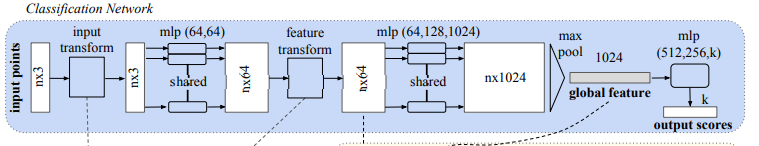

We
also add a regularization term to our softmax training
loss. We constrain the feature transformation matrix to be
close to orthogonal matrix:
### Lreg = (I − AB)^2
where A is the feature alignment matrix predicted by a
mini-network and B is its transpose matrix. An orthogonal transformation will not lose
information in the input, thus is desired. We find that by
adding the regularization term, the optimization becomes
more stable and our model achieves better performance.
This can be shown in the orthogonal regularizer network.

In [ ]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2000, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2000, 32)     128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2000, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2000, 32)     0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
308/308 [==============================] - 83s 155ms/step - loss: 5.5600 - sparse_categorical_accuracy: 0.1201 - val_loss: 6887809773700063952896.0000 - val_sparse_categorical_accuracy: 0.0770
Epoch 2/20
308/308 [==============================] - 48s 156ms/step - loss: 4.5054 - sparse_categorical_accuracy: 0.1637 - val_loss: 16176439479328833536.0000 - val_sparse_categorical_accuracy: 0.0847
Epoch 3/20
 38/308 [==>...........................] - ETA: 39s - loss: 4.4705 - sparse_categorical_accuracy: 0.1579